In [1]:
import os

import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
import numpy as np
import seaborn as sns

from REStats.utils import load_SCADA, filter_outliers
from REStats.plots import save_figs
from REStats.models import calc_iec_power_curve

In [2]:
sns.set_theme()

In [3]:
figs = {}
SAVE_FIGS = True

In [4]:
wt = load_SCADA(2020)

In [5]:
cut_out = 18.0 # TODO: infer?
wt_train = wt[["wind_speed", "power"]]
wt_train = wt_train.resample("H").mean()
wt_train.head()

wt_filtered = filter_outliers(wt_train, cut_out=cut_out)

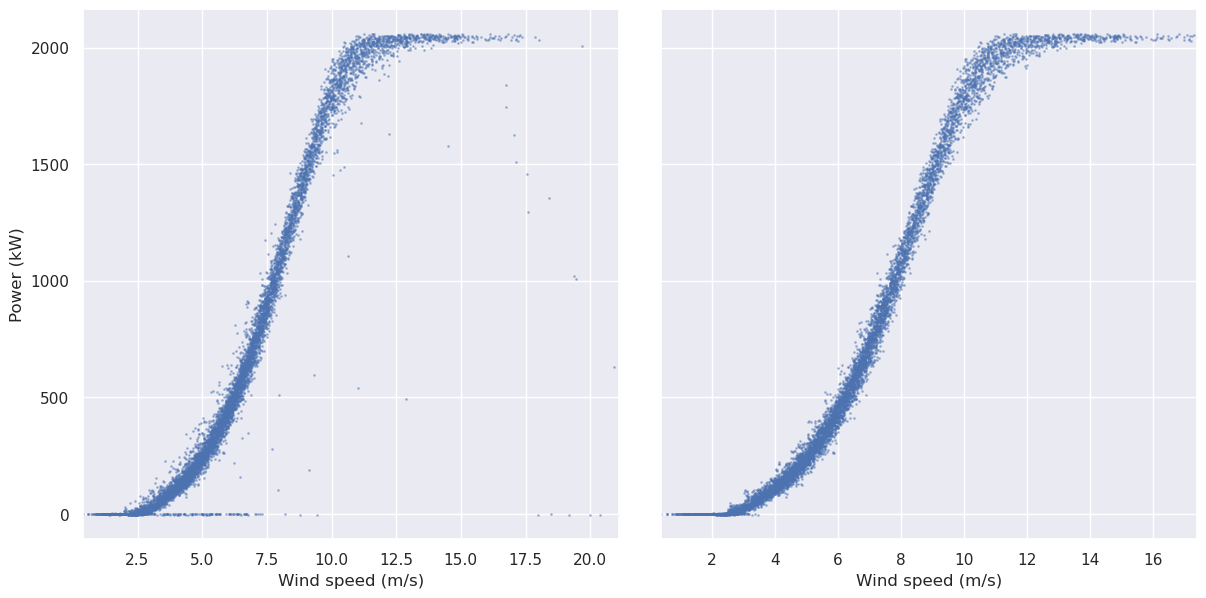

In [6]:
filtered_pc, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
filtered_pc.tight_layout()
axes[0].set_ylabel("Power (kW)")
for ax in axes:
    ax.set_xmargin(0)
    ax.set_xlabel("Wind speed (m/s)")

axes[0].scatter(wt_train.wind_speed, wt_train.power, s=1, alpha=0.4)
axes[1].scatter(wt_filtered.wind_speed, wt_filtered.power, s=1, alpha=0.4)

figs["filtered_pc"] = filtered_pc

In [7]:
iec_pc = calc_iec_power_curve(wt_train, cut_out)
iec_pc.tail()

,wind_speed,power
wind_speed,,
"(15.0, 15.5]",15.235950,2040.377001
"(15.5, 16.0]",15.750089,2040.320594
"(16.0, 16.5]",16.227438,2042.865202
"(16.5, 17.0]",16.752957,1987.308632
"(17.0, 17.5]",17.176054,1948.165161


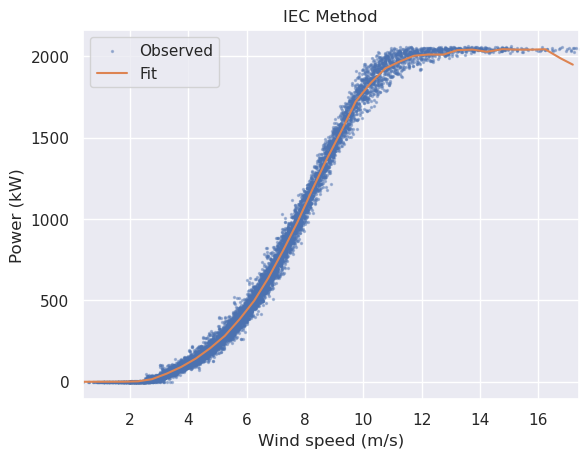

In [8]:
iec_pc_fig, ax = plt.subplots()
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")
ax.set_title("IEC Method")

ax.scatter(wt_filtered.wind_speed, wt_filtered.power, s=2, alpha=.4, color="C0", label="Observed")
ax.plot(iec_pc.wind_speed, iec_pc.power, color="C1", label="Fit")

ax.legend()

figs["iec_pc"] = iec_pc_fig

In [9]:
kbd = KBinsDiscretizer(n_bins=20, encode="ordinal")
bins = kbd.fit_transform(wt_filtered.wind_speed.to_numpy()[:, None])

train, test = train_test_split(wt_filtered, stratify=bins, train_size=200, test_size=200, random_state=1)

train["power_std"] = (train.power - train.power.mean())/train.power.std()

train

,wind_speed,power,power_std
Date,,,
2020-02-18 07:00:00,7.467836,835.262777,0.156026
2020-01-10 14:00:00,4.788829,245.124614,-0.734246
2020-05-01 17:00:00,6.544211,653.071748,-0.118824
2020-08-13 17:00:00,4.446547,181.544251,-0.830163
2020-10-29 18:00:00,11.804990,2033.229358,1.963259
...,...,...,...
2020-06-08 02:00:00,6.172963,508.523692,-0.336887
2020-04-02 05:00:00,6.201098,507.234438,-0.338832
2020-10-24 16:00:00,11.712703,2006.102288,1.922335


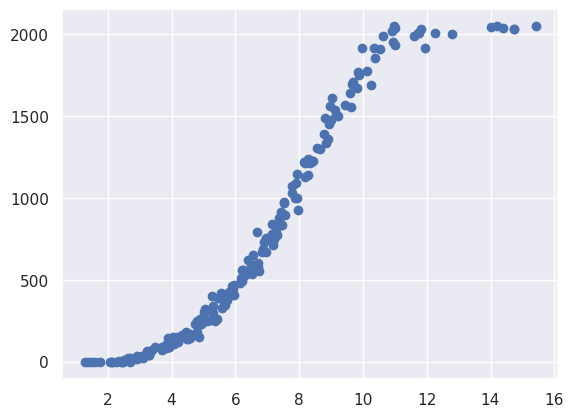

In [10]:
plt.scatter(train.wind_speed, train.power)

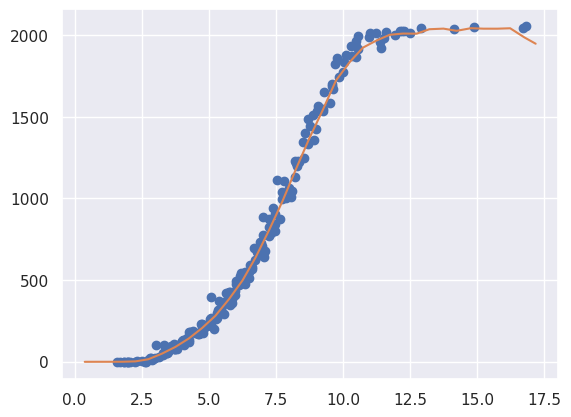

In [11]:
iec_pred = [iec_pc.loc[ws, "power"] for ws in test.wind_speed]

ws_sort = np.argsort(train.wind_speed.values)

fig, ax = plt.subplots()

ax.scatter(test.wind_speed, test.power, color="C0")
ax.plot(iec_pc.wind_speed, iec_pc.power, color="C1")

In [12]:
rmse = mean_squared_error(iec_pred, test.power, squared=False)

print("IEC Test RMSE:", rmse)

IEC Test RMSE: 54.8758152692304


In [13]:
X_prior = np.linspace(0, 18, 500)[:, None]

with pm.Model() as model_prior:                    
    ℓ = pm.Gamma("ℓ", 4, 1)
    η = pm.HalfCauchy("η", 1.5)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    
    gp = pm.gp.Latent(cov_func=cov_func)
        
    sigma = pm.HalfNormal("sigma", 1)
    
    f = gp.prior("f", X=X_prior)
    
    idata_pc_prior = pm.sample_prior_predictive(samples=10, random_seed=1)

Sampling: [f_rotated_, sigma, η, ℓ]


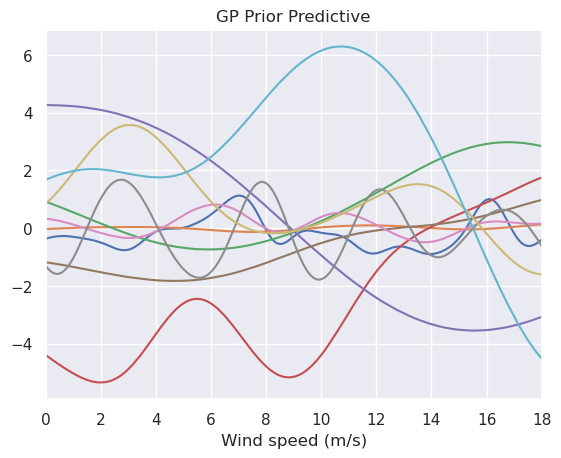

In [14]:
gp_prior, ax = plt.subplots()
ax.set_xmargin(0)
ax.set_title("GP Prior Predictive")
ax.set_xlabel("Wind speed (m/s)")

gp_ppc = idata_pc_prior.prior.f.mean(["chain"])

for gp_y in gp_ppc:
    ax.plot(X_prior, gp_y)
    
figs["gp_prior"] = gp_prior

In [15]:
idata_pc_prior

Inference data with groups:
	> prior

In [17]:
X = train.wind_speed.values[:, None]
y = train.power_std.values

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", 4, 1)
    η = pm.HalfCauchy("η", 1)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    sigma = pm.HalfNormal("sigma", 1)
    
    y_ = gp.marginal_likelihood("y", X=X, y=y, sigma=sigma)
    
    idata_pc = pm.sample(chains=2, cores=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ℓ, η, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 365 seconds.


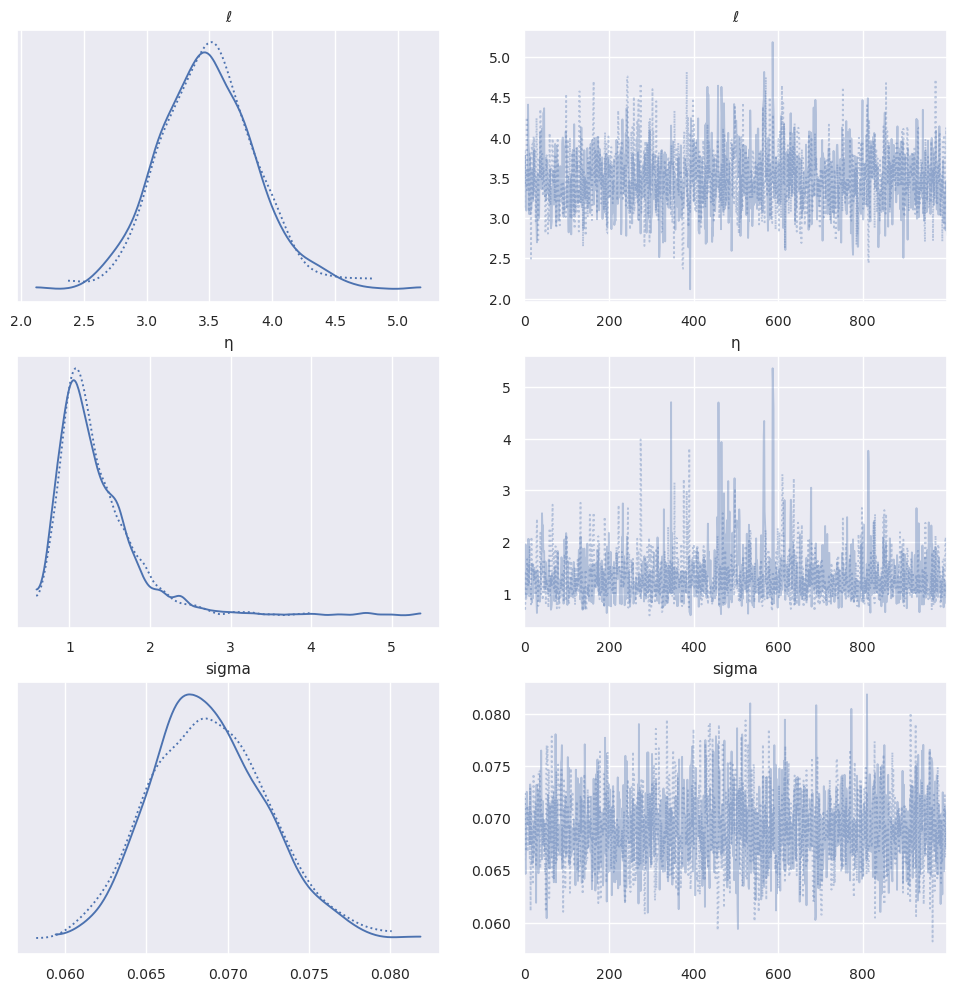

In [18]:
az.plot_trace(idata_pc, figsize=(12, 12))

pc_trace = plt.gcf()

figs["pc_trace"] = pc_trace

In [19]:
Xnew = np.linspace(0, cut_out, 100)[:, None]

with model:
    f_train = gp.conditional("f_train", Xnew=Xnew)
    f_train_samples = pm.sample_posterior_predictive(idata_pc, var_names=["f_train"])
    
    y_train = gp.conditional("y_train", Xnew=Xnew, pred_noise=True)
    y_train_samples = pm.sample_posterior_predictive(idata_pc, var_names=["y_train"])

Sampling: [f_train]


Sampling: [y_train]


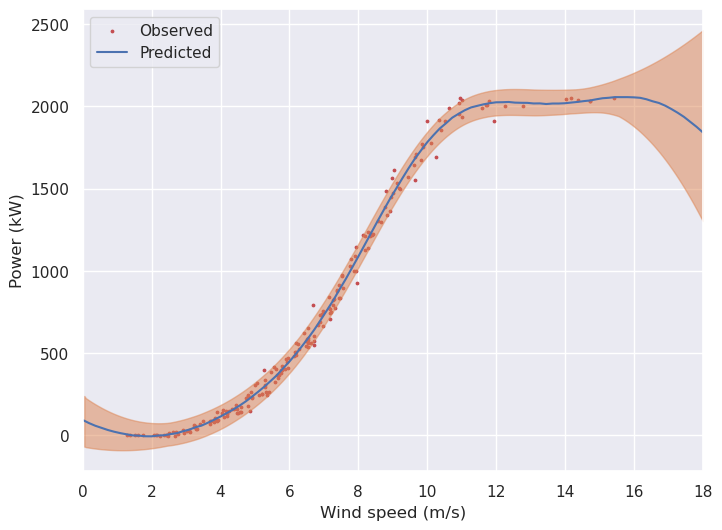

In [20]:
pc_train, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")

# f_train_pred = f_train_samples.posterior_predictive.f_train.mean(["chain", "draw"])
y_train_pred = y_train_samples.posterior_predictive.y_train.mean(["chain", "draw"])

ax.scatter(train.wind_speed, train.power, s=3, color="C3", label="Observed")
ax.plot(Xnew.flatten(), y_train_pred * train.power.std() + train.power.mean(), color="C0", label="Predicted")
az.plot_hdi(
    Xnew.flatten(), 
    y_train_samples.posterior_predictive.y_train * train.power.std() + train.power.mean(), 
    hdi_prob=.89,
)


ax.legend()

figs["pc_train"] = pc_train

In [21]:
test_sort = test.sort_values("wind_speed")

In [22]:
with model:
    X_test = test_sort.wind_speed.values[:, None]
    y_test = gp.conditional("y_test", Xnew=X_test, pred_noise=True)
    y_test_samples = pm.sample_posterior_predictive(idata_pc, var_names=["y_test"])

Sampling: [y_test]


In [23]:
y_test_pred = y_test_samples.posterior_predictive.y_test.mean(["chain", "draw"])
y_test_pred = y_test_pred * train.power.std() + train.power.mean()

test_rmse = mean_squared_error(y_test_pred, test_sort.power, squared=False)

print("Model Test RMSE:", test_rmse)

Model Test RMSE: 45.934822263126165


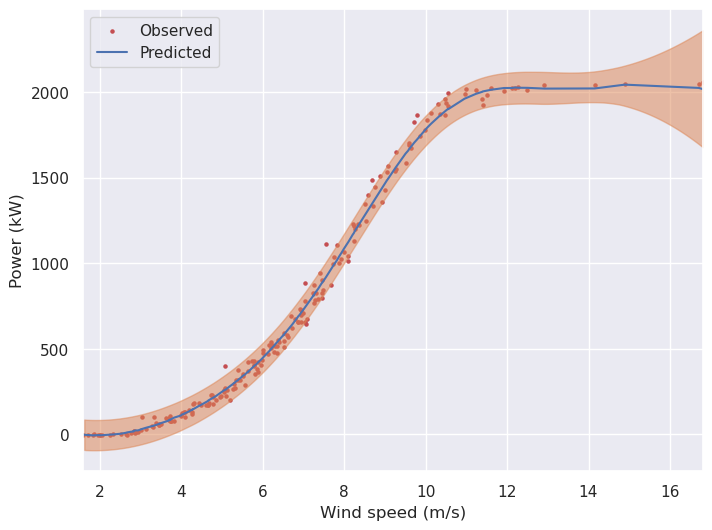

In [24]:
pc_test, ax = plt.subplots(figsize=(8, 6))
ax.set_xmargin(0)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")

ax.scatter(X_test, test_sort.power, color="C3", s=5, label="Observed")
ax.plot(X_test, y_test_pred, color="C0", label="Predicted")
az.plot_hdi(X_test.flatten(), y_test_samples.posterior_predictive.y_test * train.power.std() + train.power.mean())
ax.legend()

figs["pc_test"] = pc_test

In [25]:
if SAVE_FIGS:
    save_figs(figs)